## When do we need medical experts to annotate relations between drugs and diseases?
---

In [2]:
import pandas as pd

In [3]:
expert_table = pd.read_csv('../data/expert/expert_table.csv')
worker_table = pd.read_csv('../data/crowd/worker_table.csv')

---
## Workers vs experts (merging consensus tables)

In [4]:
label_list = ['Contraindication','Effect','IDK','Indication: Symptomatic Relief','Indication: Treatment']
label_list_expert = ['medical_expert1','medical_expert2','medical_expert3','workers_answers']
match_table = pd.merge(worker_table.drop(columns=label_list),
                       expert_table.drop(columns=label_list_expert),
                       on=['do_id','drug_id','label_id'], how='inner')

match_table['relation_match'] = match_table.worker_consensus == match_table.expert_consensus

In [5]:
match_table.head(3)

,do_id,drug_id,label_id,context_x,worker_answers,inter_agree_workers,worker_consensus,#,context_y,disease_name,drug_name,drug_brand_name,sheet,expert_consensus,inter_agree_experts,relation_match
0,DOID_0050451,DB01182,../DailyMedExtracter/prescription/temp_xml/71d...,['Propafenone hydrochloride is contraindicated...,6,0.333333,No consensus,84.0,['Propafenone hydrochloride is contraindicated...,BRUGADA SYNDROME,Propafenone HCl,NaN,indication_symptomatic_relief,Contraindication,2,False
1,DOID_0050700,DB00445,../DailyMedExtracter/prescription/temp_xml/4f9...,Patients should not be treated with epirubicin...,9,0.333333,No consensus,69.0,Patients should not be treated with epirubicin...,CARDIOMYOPATHY,Epirubicin Hydrochloride,NaN,indication_symptomatic_relief,Contraindication,2,False
2,DOID_0050820,DB01182,../DailyMedExtracter/prescription/temp_xml/71d...,['Propafenone hydrochloride is contraindicated...,3,0.666667,Effect,98.0,['Propafenone hydrochloride is contraindicated...,AV BLOCK,PROPAFENONE,Propafenone HCl,effect,Contraindication,2,False


In [6]:
match_table.shape

(359, 16)

In [7]:
match_table.worker_consensus.unique()

array(['No consensus', 'Effect', 'Contraindication',
       'Indication: Treatment', 'Indication: Symptomatic Relief'],
      dtype=object)

In [8]:
match_table.expert_consensus.unique()

array(['Contraindication', 'Indication: Treatment', 'No consensus',
       'Effect', 'Indication: Symptomatic Relief'], dtype=object)

---
### Check matches and workers accuracy

In [9]:
!pip install pycm

In [10]:
from pycm import *
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
match_table_filtered = match_table[(match_table.worker_consensus != 'No consensus') & 
                                    (match_table.expert_consensus != 'No consensus') &
                                    (match_table.worker_consensus != 'IDK') &
                                    (match_table.expert_consensus != 'IDK')]

In [12]:
match_table_filtered.shape

(261, 16)

In [13]:
y_actu = list(match_table_filtered.expert_consensus) #gold standard # X axis
y_pred = list(match_table_filtered.worker_consensus) #workers answers Y axis
cm = ConfusionMatrix(y_actu, y_pred) 

In [14]:
#plt.figure(figsize=(10,2))
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10,8))
ax= sns.heatmap(pd.DataFrame(cm.table), annot=True, cmap="YlGnBu")
#plt.xlabel('Experts'); plt.ylabel('Workers');
ax.set_xlabel('Experts');ax.set_ylabel('Workers'); 
plt.tight_layout()
#plt.show()
ax.get_figure().savefig('worker_vs_expert.png', dpi=200)
#ax.get_figure().savefig('worker_vs_expert.png', dpi=200)

#sns_plot.gesavefig('worker_vs_expert.jpg')

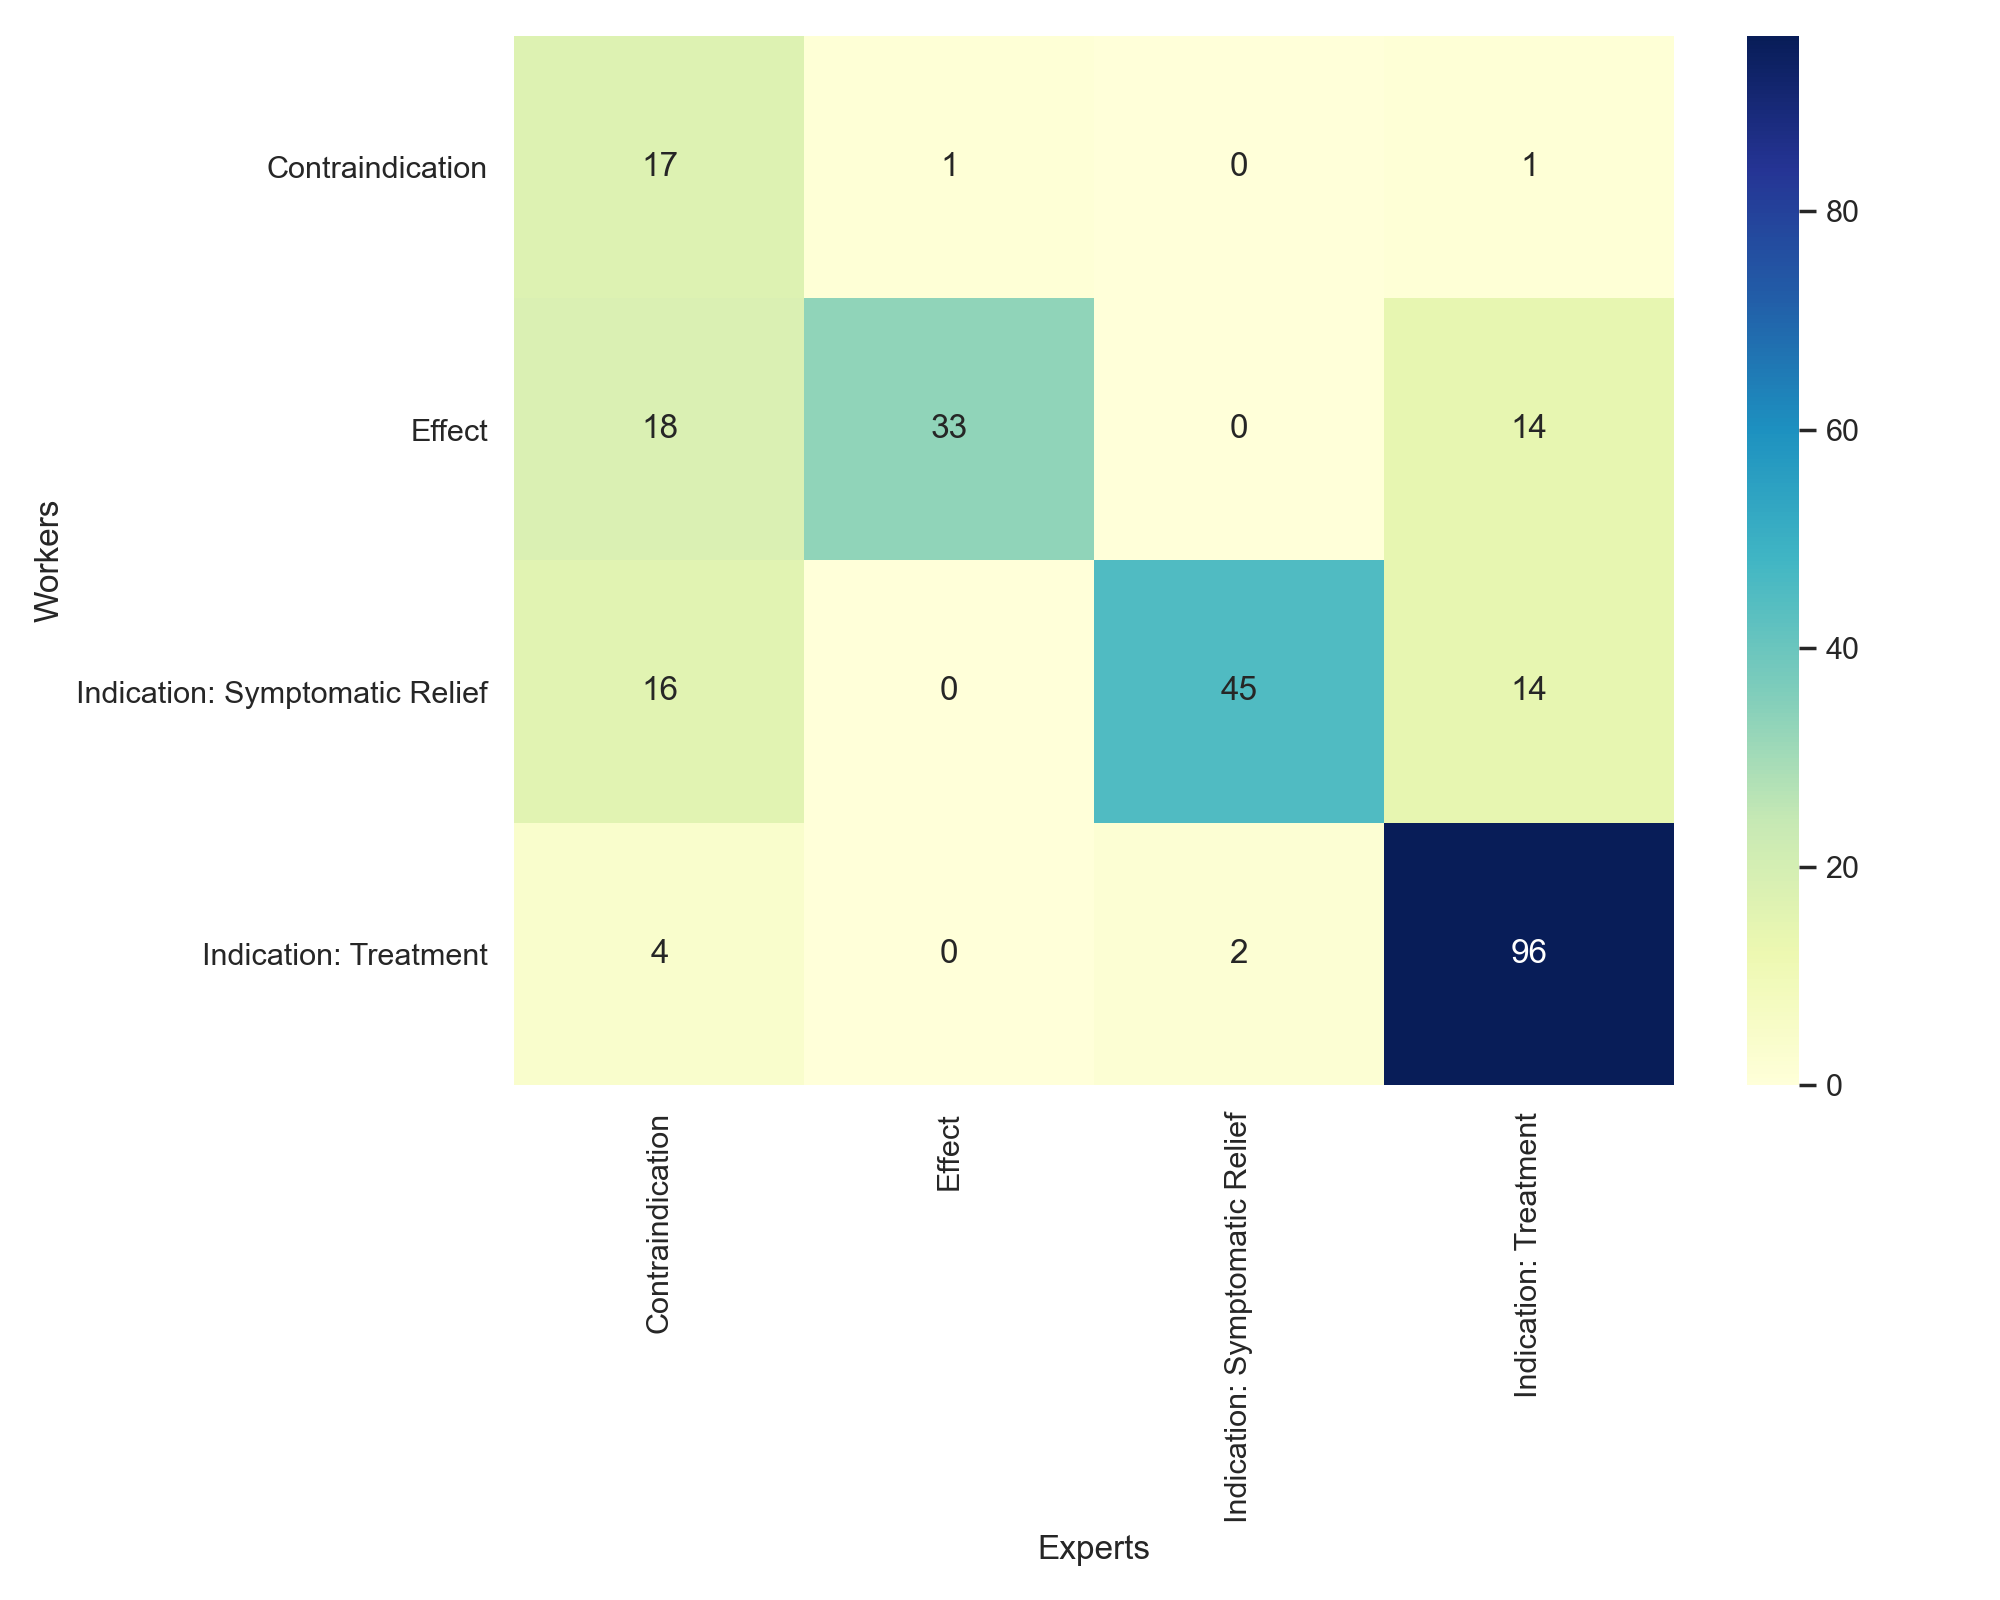

In [15]:
from IPython.display import Image
Image(filename='worker_vs_expert.png') 

In [16]:
cm.ACC

{'Contraindication': 0.8467432950191571,
 'Effect': 0.8735632183908046,
 'Indication: Symptomatic Relief': 0.8773946360153256,
 'Indication: Treatment': 0.8659003831417624}

In [17]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(match_table_filtered['worker_consensus'],match_table_filtered['expert_consensus'])

0.6240044452676422

In [20]:
num_match = len(match_table_filtered[match_table_filtered['worker_consensus'] ==match_table_filtered['expert_consensus']])

In [21]:
num_match/len(match_table_filtered)

0.7318007662835249

**Workers find more diffult to annotate contraindication the most**

In [15]:
print('Workers were as good as medical experts in {}% of the cases'.format(round(cm.Overall_ACC*100,2)))

Workers were as good as medical experts in 72.76% of the cases


---
## Questions:
### - What are the characteristics of contexts that makes diffucult for the crowd to have consensus?
### - Can we train a ML method that learns when the crowd will perform as good as the experts?

Temptative features to be extracted
- lenght of text
- number of words
- particular words used on medical domain misinterpreted
- amount of medical terminology
- multiple concepts at once
- long distance between disease, drug and relation

Tenmptative groups to analyze
- Excluding the No concensus of the experts, analyze the miss match of workers
- All those answers with match, compare the label match vs concensus match
- Where do experts disagree but workers don't

---

In [16]:
#text lenght
match_table['total_characters'] = [len(text) for text in match_table['context_x']]
match_table['total_words'] = [len(text.replace('\n',' ').split()) for text in match_table['context_x']]

In [17]:
match_table.to_csv('../data/expert/experts_vs_crowd_working_table.csv',index=False)

In [18]:
subset_consensus = match_table[(match_table.expert_consensus != 'No consensus') & (match_table.expert_consensus != 'IDK')]

In [19]:
subset_consensus.groupby('relation_match').describe().T#.reset_index()

relation_match                   False        True 
worker_answers      count   136.000000   195.000000
                    mean      5.073529     4.466667
                    std       4.076368     5.384463
                    min       3.000000     3.000000
                    25%       3.000000     3.000000
                    50%       3.000000     3.000000
                    75%       6.000000     3.000000
                    max      25.000000    32.000000
inter_agree_workers count   136.000000   195.000000
                    mean      0.546467     0.878759
                    std       0.182771     0.160502
                    min       0.250000     0.555556
                    25%       0.333333     0.666667
                    50%       0.666667     1.000000
                    75%       0.666667     1.000000
                    max       1.000000     1.000000
#                   count   136.000000   195.000000
                    mean     53.838235    46.984615
                    std      32.829576    28.026217
                    min       1.000000     1.000000
                    25%      24.750000    21.500000
                    50%      59.500000    46.000000
                    75%      82.250000    69.000000
                    max     102.000000   101.000000
inter_agree_experts count   136.000000   195.000000
                    mean      2.330882     2.538462
                    std       0.472270     0.499802
                    min       2.000000     2.000000
                    25%       2.000000     2.000000
                    50%       2.000000     3.000000
                    75%       3.000000     3.000000
                    max       3.000000     3.000000
total_characters    count   136.000000   195.000000
                    mean    998.882353  1003.774359
                    std     726.064257   755.038512
                    min      81.000000   126.000000
                    25%     410.500000   464.000000
                    50%     832.000000   756.000000
                    75%    1462.500000  1327.000000
                    max    3060.000000  3511.000000
total_words         count   136.000000   195.000000
                    mean    134.183824   133.717949
                    std      98.404547    99.222428
                    min      11.000000    17.000000
                    25%      56.000000    60.500000
                    50%     110.000000    99.000000
                    75%     197.000000   175.500000
                    max     381.000000   393.000000

## Statistical difference in means

In [20]:
subset_matches = subset_consensus[subset_consensus['relation_match']==True]
subset_missmatches = subset_consensus[subset_consensus['relation_match']==False]

In [21]:
from scipy import stats

In [22]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.inter_agree_workers
workers_failed = subset_missmatches.inter_agree_workers
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average workers interate agreement on success: {}\naverage workers interate agreement on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

average workers interate agreement on success: 0.8787588025787679
average workers interate agreement on failure: 0.5464665032679741


/Users/remzicelebi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:347: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, auto=None)


Ttest_indResult(statistic=17.097245704059148, pvalue=1.0313095811028641e-44)

**Workers perform as good as experts when there is more agreement among workers**

In [23]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.inter_agree_experts
workers_failed = subset_missmatches.inter_agree_experts
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average experts interate agreement on success: {}\naverage experts interate agreement on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

average experts interate agreement on success: 2.5384615384615383
average experts interate agreement on failure: 2.3308823529411766


Ttest_indResult(statistic=3.840748614415999, pvalue=0.00014961692310083333)

**Workers perform as good as experts when there is more agreement among experts also**

In [24]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.total_words
workers_failed = subset_missmatches.total_words
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average total words on success: {}\naverage total words on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

average total words on success: 133.71794871794873
average total words on failure: 134.18382352941177


Ttest_indResult(statistic=-0.04223209722337519, pvalue=0.966342526462888)

**It does not matter the number of words in the text on workers successes**

In [25]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.total_characters
workers_failed = subset_missmatches.total_characters
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average total characters on success: {}\naverage total characters on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

average total characters on success: 1003.774358974359
average total characters on failure: 998.8823529411765


Ttest_indResult(statistic=0.05932538525026393, pvalue=0.9527327562649665)

**It does not matter the lenght of characters in the text on workers successes**

---
### Can we predict the crowd will perform as good as an expert based on the features

In [27]:
# RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# split data into X and y
features = ['inter_agree_workers','total_characters','total_words','worker_consensus']
X = subset_consensus[features]
X.worker_consensus = X.worker_consensus.replace({'No consensus':0, 'Effect':1, 'Contraindication':2,
       'Indication: Treatment':3, 'Indication: Symptomatic Relief':4})
Y = subset_consensus['relation_match']
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = RandomForestClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.09%


/Users/remzicelebi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
subset_consensus.head()

,do_id,drug_id,label_id,context_x,worker_answers,inter_agree_workers,worker_consensus,#,context_y,disease_name,drug_name,drug_brand_name,sheet,expert_consensus,inter_agree_experts,relation_match,total_characters,total_words
0,DOID_0050451,DB01182,../DailyMedExtracter/prescription/temp_xml/71d...,['Propafenone hydrochloride is contraindicated...,6,0.333333,No consensus,84.0,['Propafenone hydrochloride is contraindicated...,BRUGADA SYNDROME,Propafenone HCl,NaN,indication_symptomatic_relief,Contraindication,2,False,929,116
1,DOID_0050700,DB00445,../DailyMedExtracter/prescription/temp_xml/4f9...,Patients should not be treated with epirubicin...,9,0.333333,No consensus,69.0,Patients should not be treated with epirubicin...,CARDIOMYOPATHY,Epirubicin Hydrochloride,NaN,indication_symptomatic_relief,Contraindication,2,False,665,82
2,DOID_0050820,DB01182,../DailyMedExtracter/prescription/temp_xml/71d...,['Propafenone hydrochloride is contraindicated...,3,0.666667,Effect,98.0,['Propafenone hydrochloride is contraindicated...,AV BLOCK,PROPAFENONE,Propafenone HCl,effect,Contraindication,2,False,929,116
3,DOID_0050820,DB00187,../DailyMedExtracter/prescription/temp_xml/6bb...,['Esmolol hydrochloride injection is contraind...,3,0.666667,Contraindication,55.0,['Esmolol hydrochloride injection is contraind...,ATRIOVENTRICULAR BLOCK,ESMOLOL,Esmolol Hydrochloride,contraindication,Contraindication,2,True,1882,262
4,DOID_0050820,DB00343,../DailyMedExtracter/prescription/temp_xml/10d...,Diltiazem hydrochloride injection is contraind...,3,0.666667,Effect,98.0,Diltiazem hydrochloride injection is contraind...,AV BLOCK,DILTIAZEM,Diltiazem Hydrochloride,contraindication,Contraindication,3,False,1759,230


In [29]:
cmx = ConfusionMatrix([float(i ==True) for i in y_test], list(predictions)) 

In [30]:
sns.heatmap(pd.DataFrame(cmx.table), annot=True, cmap="YlGnBu")